This notebook demonstrates how to use ``auto_arima`` to fit an ARIMA model to perform forecasting. 

In [1]:
import pmdarima
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from utils import plot_PIs, compute_coverage_len
import data_loaders
from tqdm import tqdm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import arch

## Data loading and preprocessing

In this example, we consider solar energy production data. We specify the forecast ``horizon`` variable and the main ``seasonality`` in the time series (in this case ``seasonality=24`` since the data have hourly resolution). We also specify the ``target`` variable that we want to predict.

In [2]:
# load data
train_df, _, test_df = data_loaders.get_solar_data()
horizon=24
seasonality=24
target='MWH'

# we use a subset of the actual dataset in this example 
train_df = train_df[:2000]
test_df = test_df[:1000]

Next we separate the target variable from the other variables, which are used as exogenous variables.

In [3]:
# separate exogenous variables (x) from the target variable (y)
y_train = train_df[target].values
x_train = train_df.drop(target, axis=1).values
y_test = test_df[target].values
x_test = test_df.drop(target, axis=1).values

print(f"y_train: {y_train.shape}, x_train: {x_train.shape}, y_test: {y_test.shape}, x_test: {x_test.shape}")

y_train: (2000,), x_train: (2000, 5), y_test: (1000,), x_test: (1000, 5)


Finally, we normalize the data in the range $[-1,1]$. We use a different scaler for the exogenous variables ($x$) and the target variable ($y$).

In [4]:
# instantiate the scaler
y_scaler = MinMaxScaler()
x_scaler = MinMaxScaler()

# Normalize data
y_train = y_scaler.fit_transform(y_train[...,None])
x_train = x_scaler.fit_transform(x_train)
y_test = y_scaler.transform(y_test[...,None])
x_test = x_scaler.transform(x_test)

## ARIMA model

### Fit the ARIMA model
We use ``auto_arima`` to find the best ARIMA model for the data at hand. The procedure takes a while. 

In [5]:
# automatically fit the optimal ARIMA model for given time series
arima_model = pmdarima.auto_arima(
    y_train, exogenous=x_train,
    start_p=1, start_q=1,
    max_p=4, max_q=4, m=seasonality,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',   # don't want to know if an order does not work
    suppress_warnings=True,  # don't want convergence warnings
    stepwise=True)
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=inf, Time=10.45 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=-2737.628, Time=0.21 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=-3064.876, Time=2.47 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=6.92 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=-2739.765, Time=0.54 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=-3163.848, Time=9.57 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=26.42 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=inf, Time=8.02 sec
 ARIMA(0,1,0)(2,1,0)[24]             : AIC=-3145.571, Time=8.68 sec
 ARIMA(2,1,0)(2,1,0)[24]             : AIC=-3218.429, Time=18.22 sec
 ARIMA(2,1,0)(1,1,0)[24]             : AIC=-3109.748, Time=3.12 sec
 ARIMA(2,1,0)(2,1,1)[24]             : AIC=inf, Time=35.96 sec
 ARIMA(2,1,0)(1,1,1)[24]             : AIC=inf, Time=11.51 sec
 ARIMA(3,1,0)(2,1,0)[24]             : AIC=-3222.841, Time=12.69 sec
 ARIMA(3,1,0)(1,1,0)[24]           

After the model is fit, we collect the training residuals $\epsilon_t = \hat{y}_t - y_t$. The residuals give us an idea of how well the ARIMA model fits the training data.

In [6]:
# collect training residuals
train_res = arima_model.arima_res_.resid

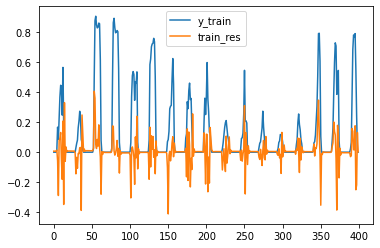

In [7]:
# plot residuals and training data
plt.plot(y_train[100:500], label='y_train')
plt.plot(train_res[100:500], label='train_res')
plt.legend()
plt.show()

Ideally, the residuals should be pure noise and, thus, uncorrelated with each other. To check this, we look at the autocorrelation and partial autocorrelation plots.

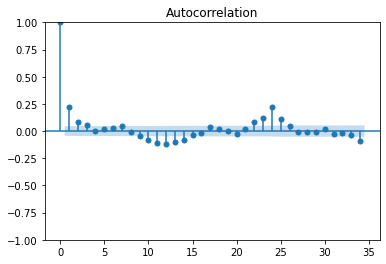

In [8]:
squared_train_res = train_res**2 
plot_acf(squared_train_res)
plt.show()

C:\Users\fmbia\anaconda3\envs\spektral_tf2\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


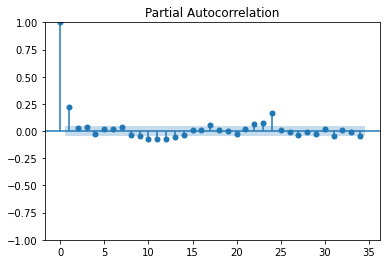

In [9]:
plot_pacf(squared_train_res)
plt.show()

We see that there are some correlations left in the residuals, meaning that the ARIMA model was not able to fully explain the variability in the data.

### Make predictions

Now that the model is fit, we can use it to make predictions at ``horizon`` steps ahead. After making each prediction, we update the ARIMA model with the new data as they become available. Also, we collect the residuals on the test data and the CI at the $\alpha=0.1$ confidence level. 

In [10]:
# Make predictions and update the model
pred_list, ci_list, res_list = [], [], []
for step in tqdm(range(y_test.shape[0]//horizon)):
    y_hat, conf_int = arima_model.predict(n_periods=horizon, return_conf_int=True, alpha=0.1)
    pred_list.append(y_hat)
    ci_list.append(conf_int)
    res_list.append(y_test[step*horizon:(step+1)*horizon, 0] - y_hat)
    arima_model.update(
        y_test[step*horizon:(step+1)*horizon], 
        exogenous=x_test[step*horizon:(step+1)*horizon])
    
# collect predictions, CI, and residuals
preds = np.hstack(pred_list)[...,None]
preds_ci = np.vstack(ci_list)
test_res = np.hstack(res_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [07:31<00:00, 11.01s/it]


In [11]:
# post-process output
y_hat = y_scaler.inverse_transform(preds)
y_hat_ci = y_scaler.inverse_transform(preds_ci)
y_test = y_scaler.inverse_transform(y_test[:preds.shape[0]])

<Figure size 432x288 with 0 Axes>

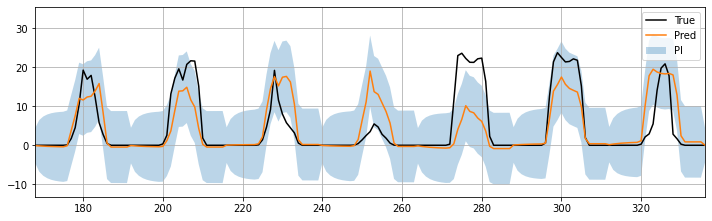

PI coverage: 87.8%, PI avg. length: 0.679, CWC: 0.316


In [12]:
# plot and print arima results
plot_PIs(y_test[:preds.shape[0]], y_hat, y_hat_ci[:,0], y_hat_ci[:,1], x_lims=[168,336])
compute_coverage_len(y_test[:preds.shape[0],0], y_hat_ci[:,0], y_hat_ci[:,1], verbose=True)

## GARCH models (bonus)

ARIMA models do not model a change in the variance over time. On the other hand, an ARCH method models the variance at a time step as a function of the residual errors from a mean process. ARCH expects the series to be stationary (besides the change in variance) meaning it does not have a trend or seasonal component.
In practice, ARCH can be used to model the variance of the residuals obtained from an ARIMA model.

Generalized Autoregressive Conditional Heteroskedasticity (GARCH), is an extension of the ARCH model that incorporates a MA component together with the AR component.
The introduction of a MA component allows GARCH to both model the conditional change in variance over time as well as changes in the time-dependent variance.

Similarly to ARIMA, GARCH is parametrized by
- p: the number of lag variances.
- q: the number of lag residual errors.

In this example, we set $p=1$ and $q=2$.

In [13]:
tot_res = np.concatenate((train_res, test_res))

# specify garch model
garch = arch.arch_model(
    tot_res, 
    vol='garch', 
    p=1, q=2)

# fit the garch model
garch_fitted = garch.fit(
    last_obs=train_res.shape[0] # specify where train data ends
    )

Iteration:      1,   Func. Count:      7,   Neg. LLF: -1919.3304242235713
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1919.3501162801922
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1970.3600126249478
Iteration:      4,   Func. Count:     35,   Neg. LLF: -2030.1051280087415
Iteration:      5,   Func. Count:     43,   Neg. LLF: -2080.730276306716
Iteration:      6,   Func. Count:     51,   Neg. LLF: -2113.2054416972387
Iteration:      7,   Func. Count:     59,   Neg. LLF: -2127.6607800755505
Iteration:      8,   Func. Count:     67,   Neg. LLF: -2145.827747839727
Iteration:      9,   Func. Count:     75,   Neg. LLF: -2149.7023924283303
Iteration:     10,   Func. Count:     83,   Neg. LLF: -2156.879458841089
Iteration:     11,   Func. Count:     91,   Neg. LLF: -2157.896686173708
Iteration:     12,   Func. Count:     98,   Neg. LLF: -2159.0165947378964
Iteration:     13,   Func. Count:    105,   Neg. LLF: -2159.0757730620835
Iteration:     14,   Func. Count:    112, 

C:\Users\fmbia\anaconda3\envs\spektral_tf2\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [14]:
# forecasts with garch
garch_forecast = garch_fitted.forecast(
    start=train_res.shape[0], # specify where forecasting starts
    horizon=horizon, 
    )

garch_var = garch_forecast.variance['h.'+str(horizon)].iloc[train_res.shape[0]:].values
garch_mean = garch_forecast.mean['h.'+str(horizon)].iloc[-test_res.shape[0]:].values

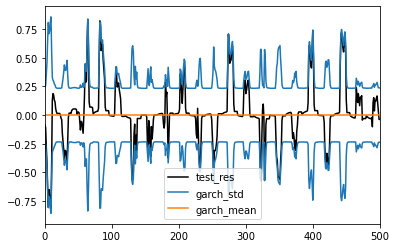

In [15]:
plt.plot(test_res, label='test_res', color='k')
plt.plot(garch_mean-np.sqrt(garch_var), color=plt.cm.tab10(0), label='garch_std')
plt.plot(garch_mean+np.sqrt(garch_var), color=plt.cm.tab10(0))
plt.plot(garch_mean, color=plt.cm.tab10(1), label='garch_mean')
plt.xlim([0,500])
plt.legend()
plt.show()

In [16]:
# post-process output
garch_std = np.sqrt(garch_var)[...,None]
garch_ci_low = y_scaler.inverse_transform(preds-garch_std)
garch_ci_hi = y_scaler.inverse_transform(preds+garch_std) 

<Figure size 432x288 with 0 Axes>

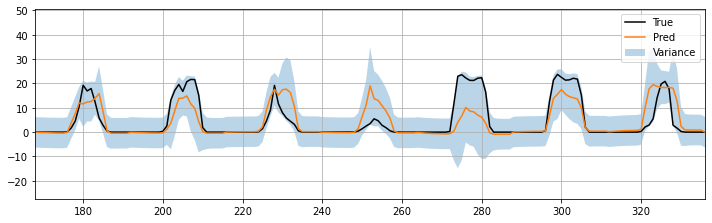

In [17]:
# plot garch results
plot_PIs(y_test, y_hat, garch_ci_low, garch_ci_hi, x_lims=[168,336], label_pi='Variance')

It is important to notice that now the area in blue is not a confidence interval, but rather the predicted variance.